## DATA 558 - Homework 4
#### Anushna Prakash
#### April 30th, 2021

##### Coordinate Descent
$$
F(\beta) = \frac{1}{2} (y - x\beta)^2 + \lambda|\beta|
$$

Implement soft-thresholding in the $n = d = 1$ case. Assume $x = y = 1$ and $\lambda = 0.5$  
$$
    \beta = 
    \begin{cases}
        \frac{xy - \lambda}{x^2}, & \text{for } xy > \lambda\\
        0, & \text{for } |xy| \leq \lambda\\
        \frac{xy + \lambda}{x^2}, & \text{for } xy < \text{-}\lambda
    \end{cases}
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso

In [2]:
def f(beta, x, y, lambda_):
    """
    Returns the objective for simplified LASSO regression.
    
    Parameters
    ----------
    beta : float
    x : float
    y : float
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    objective : float
        The objective function value
    """
    return (1/2) * (y - x * beta)**2 + lambda_* np.abs(beta)

def soft_thresholding(x, y, lambda_):
    """
    Returns the beta that minimizes the soft threshold for simplified LASSO.
    
    Parameters
    ----------
    x : float
    y : float
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    beta : float
        The beta that minimizes objective function value
    """
    if (x * y) > lambda_:
        return (x*y - lambda_) / x**2
    elif (x * y) < -lambda_:
        return (x*y + lambda_) / x**2
    else:
        return 0

In [3]:
lambda_ = 0.5
x = 1
y = 1
beta = np.arange(-2, 2, 0.5)
obj = f(beta, x, y, lambda_)
st = soft_thresholding(x, y, lambda_)

Text(0, 0.5, '$F(\\beta)$')

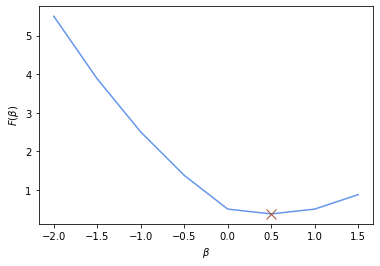

In [4]:
plt.plot(beta, obj, c = "cornflowerblue")
plt.plot(st, f(st, x, y, lambda_), marker = 'x', markersize = 10, c = 'sienna')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$F(\beta)$')

Now, assuming that $d > 1$ and $n > 1$, the objective function is:  
$$
F(\beta) = \frac{1}{2n} \sum_{i=1}^{n}(y_i - x_i^T \beta)^2 + \lambda ||\beta||_1
$$

Written with matrices, it is:  
$$
F(\beta) = \frac{1}{2n} (Y - X^T \beta)^2 + \lambda ||\beta||_1
\\ F(\beta) = \frac{1}{2n} (Y - X_{\text{-j}}^T \beta_{\text{-j}} - X_{j}^T \beta_{j})^2 + \lambda ||\beta||_1
$$

The soft thresholding minimum to the above equation is given by:
$$
    \beta = 
    \begin{cases}
        \frac{xy - \lambda}{x^2}, & \text{for } xy > \lambda\\
        0, & \text{for } |xy| \leq \lambda\\
        \frac{xy + \lambda}{x^2}, & \text{for } xy < -\lambda
    \end{cases}
$$

In [5]:
def computeobj(beta, X, y, lambda_):
    """
    Returns the objective for LASSO regression.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    
    Returns
    -------
    objective : float
        The objective function value
    """
    resid = y - np.dot(X, beta)
    return 1/2 * np.mean(resid**2) + lambda_ * np.linalg.norm(beta, ord = 1)

In [6]:
# Generate new data
np.random.seed(123)
X = np.random.normal(size=(10, 2))
beta = np.array([2.0, -5.0])
y = np.dot(X, beta) + np.random.normal(10)
lam = 3.0

In [7]:
def plot_objective(X, y, computeobj, lambda_, min_beta=None, iterates=None):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    
    z = np.array([computeobj(beta, X, y, lambda_) for
                  beta in zip(b1.ravel(), b2.ravel())])
    
    levels=np.logspace(-5,4,100)
    
    plt.figure(figsize=(6,6))
    plt.hlines(y=0, xmin=-10, xmax=10, color='k')
    plt.vlines(x=0, ymin=-10, ymax=10, color='k')
    
    if min_beta is not None:
        plt.scatter(min_beta[0], min_beta[1], marker="x", s=100, color='k')
    
    if iterates is not None:
        # Arrows.
        for j in range(1, len(iterates)):
            plt.annotate(
                "",
                xy=iterates[j],
                xytext=iterates[j - 1],
                arrowprops={"arrowstyle": "->", "color": color, "lw": 1},
                va="center",
                ha="center",
            )
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels)

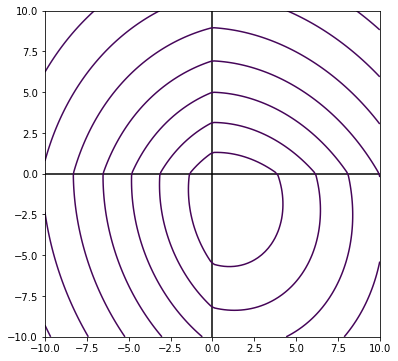

In [8]:
plot_objective(X, y, computeobj, lam)

In [9]:
def partial_min(j, beta, X, y, lambda_):
    """
    Returns the beta that partially minimizes multi-dimensional LASSO.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    j : int
        Index in [0, d-1] for the beta that will be partially minimized
    
    Returns
    -------
    beta : 1D array
        The betas that partially minimizes the function with respect to the jth index
    """
    n = len(y)

    X_j = X[:, j]
    X_ = np.delete(X, j, axis = 1)
    beta_ = np.delete(beta, j)

    r = y - X_ @ beta_ # residual excluding jth feature
    z = np.sum(X_j**2) # squared observations for the jth feature
    beta_tilde = beta.copy()
    gof = 1/n * X_j.T @ r # goodness-of-fit measure partial derivative
    
    if gof < -lambda_:
        beta_tilde[j] = (gof + lambda_) / (1/n * z)
    elif gof > lambda_:
        beta_tilde[j] = (gof - lambda_) / (1/n * z)
    else:
        beta_tilde[j] = 0
    
    return beta_tilde

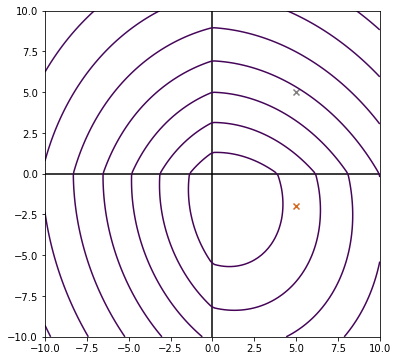

In [10]:
beta_init = np.array([5.0, 5.0])
j = 1

min_beta = partial_min(j, beta_init, X, y, lam)
plot_objective(X, y, computeobj, lam)
plt.scatter(min_beta[0], min_beta[1], marker = 'x', c = 'chocolate')
plt.scatter(beta_init[0], beta_init[1], marker = 'x', c = 'grey')

##### (d) Download the superconductivity dataset

In [11]:
conduct = pd.read_csv('HW4_data.csv', sep = ',')
conduct.head()

,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,...,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,critical_temp
0,84.231574,57.842763,66.164102,36.112184,1.430024,1.138253,122.90607,33.640786,47.428396,53.589094,...,1009.946857,752.280835,937.287219,1.545214,0.812484,810.6,749.048857,294.283693,356.200361,5.0
1,88.944468,57.894262,66.361592,36.124868,1.181795,0.932518,122.90607,37.319570,51.968828,53.669752,...,1011.040571,718.152900,939.406232,1.305967,0.764604,810.6,746.035714,323.811808,354.499974,10.2
2,75.100250,51.579798,61.298642,35.158873,1.456708,1.390133,121.32760,19.623906,39.288902,44.284202,...,998.089172,705.732671,930.382127,1.542128,0.937941,810.6,690.345940,291.828474,346.349554,75.0
3,74.231650,51.480943,60.515221,35.113886,1.453747,1.340115,121.32760,20.650805,39.445875,44.246346,...,1003.200310,771.891022,937.305449,1.552506,0.929772,810.6,694.888235,282.395259,341.811885,53.0
4,119.942725,91.077409,90.003794,73.231604,1.590565,1.551095,191.20060,29.007229,70.961415,55.280514,...,721.865714,701.448928,687.113728,1.733547,1.540374,786.5,192.422857,268.928309,255.944162,90.0


In [12]:
# Standardize X, center y
X_us = conduct.drop(['critical_temp'], axis = 1).to_numpy()
y_uc = conduct['critical_temp'].to_numpy()

X = StandardScaler().fit_transform(X_us)
y = (y_uc - np.mean(y_uc)) / np.std(y_uc)

In [13]:
# Find suitable choice for lambda using LassoCV
n = len(y)
alphas = np.logspace(-2, 2, 31)
lasso_5 = LassoCV(alphas = alphas,
                  cv = 5,
                  random_state = 42).fit(X, y)
lasso_n = LassoCV(alphas = alphas,
                  cv = n,
                  random_state = 42).fit(X, y)
alpha_k = lasso_5.alpha_
alpha_n = lasso_n.alpha_

In [14]:
print(alpha_k)
print(alpha_n)

0.025118864315095794
0.018478497974222907


In [15]:
def mse(pred, truth):
    return np.linalg.norm(pred - truth)**2

print(mse(lasso_5.predict(X), y))
print(mse(lasso_n.predict(X), y))

29.46425204627238
29.071388139212686


5-fold CV yields $\alpha = 0.025$ as the optimal hyperparameter. N-Fold or leave-one-out CV yields $\alpha=0.018$ as the optimal hyperparameter. Both have similar MSEs, though N-fold CV is slightly lower.

In [16]:
def cycliccoordinatedescent(beta_init, max_iter, *args):
    """
    Returns the betas that minimizes multi-dimensional LASSO.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    max_iter : int
    
    Returns
    -------
    betas : A list of 1D arrays
    """
    betas = [beta_init]
    beta = beta_init
    
    for i in range(max_iter):
        j = i % len(beta_init)
        beta = partial_min(j, beta, *args)
        betas.append(beta)

    return betas

In [17]:
def randcoordinatedescent(beta_init, max_iter, *args):
    """
    Returns the betas that minimizes multi-dimensional LASSO.
    
    Parameters
    ----------
    beta : 1D array
        A numpy array with shape 1 x d
    X : ndarray
        A numpy array of standardized feature variables with shape n x d
    y : 1D array
        A numpy array of standardized response variables with shape 1 x n
    lambda_ : float
        Regularization parameter
    max_iter : int
    
    Returns
    -------
    betas : A list of 1D arrays
    """
    betas = [beta_init]
    beta = beta_init
    
    for i in range(max_iter):
        j = np.random.choice(len(beta))
        beta = partial_min(j, beta, *args)
        betas.append(beta)
    
    return betas

Here I will run cyclic gradient descent and random gradient descent using the hyperparameter chosen by `sklearn`'s leave-one-out cross-validation.

In [18]:
np.random.seed(150)

beta_init = np.zeros(X.shape[1])
max_iter = 20000

b_cyclic = cycliccoordinatedescent(beta_init, max_iter, X, y, alpha_n)
b_rand = randcoordinatedescent(beta_init, max_iter, X, y, alpha_n)

f_c = [computeobj(b, X, y, alpha_n) for b in b_cyclic]
f_r = [computeobj(b, X, y, alpha_n) for b in b_rand]

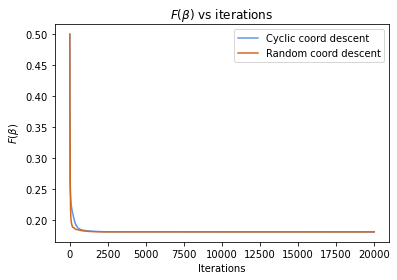

In [19]:
plt.plot(f_c, c = 'cornflowerblue')
plt.plot(f_r, c = 'chocolate')
plt.xlabel('Iterations')
plt.ylabel(r'$F(\beta)$')
plt.title(r'$F(\beta)$ vs iterations')
plt.legend(labels = ['Cyclic coord descent', 'Random coord descent'])

In [20]:
b_star = lasso_n.coef_
f_star = computeobj(b_star, X, y, alpha_n)
print("B_star:  ", b_star)
print("B_cyclic: ", b_cyclic[-1])
print("B_rand:   ", b_rand[-1])
print("F_star:   ", f_star)
print("F_cyclic: ", f_c[-1])
print("F_rand:   ", f_r[-1])

B_star:   [-0.         -0.         -0.46822758 -0.          0.          0.
  0.05253843 -0.27059755  0.43526281  0.         -0.         -0.
 -0.         -0.5967863   0.          0.          0.08993348 -0.
 -0.          0.        ]
B_cyclic:  [ 0.          0.         -0.46825823  0.          0.          0.
  0.05172216 -0.27071952  0.43599127  0.          0.          0.
  0.         -0.59689861  0.          0.          0.08994265  0.
  0.          0.        ]
B_rand:    [ 0.          0.         -0.46825823  0.          0.          0.
  0.05172216 -0.27071952  0.43599127  0.          0.          0.
  0.         -0.59689861  0.          0.          0.08994265  0.
  0.          0.        ]
F_star:    0.1807127037485472
F_cyclic:  0.18071268216620864
F_rand:    0.18071268216620864


`sklearn`, cyclic coordinate descent, and random coordinate descent all have very similar and low objective values. For our purposes, they are basically identical solutions. This is to be expected, because `sklearn` is minimizing the same objective function as what we have implemented. All methods selected the same features and have similar magnitude of the coefficients.

In [21]:
lasso_feats = np.nonzero(b_star)[0]
features = conduct.drop(['critical_temp'], axis = 1)
features.columns[lasso_feats]

Index(['gmean_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_gmean_fie', 'range_fie'],
      dtype='object')

Coordinate descent selected only 6 of 20 features, which are listed above. That is a reduction of 60% of the features. 

In [22]:
def compute_reg_path(X, y, lams):
    betas = [Lasso(alpha = l).fit(X, y).coef_ for l in lams]
    
    return np.array(betas)

def plot_reg_path(coefs, lams, features):
    d = coefs.shape[1]
    features = features.columns
    plt.figure(figsize=(20, 10), dpi = 80)

    for j in range(d):
        plt.plot(np.log(lams), coefs[:, j], label = features[j])
        
    plt.gca().invert_xaxis() # plot w/ lambda decreasing from left to right
    plt.xlabel(r'$\log \lambda$')
    plt.ylabel('LASSO parameter')
    plt.legend(frameon=False, loc='upper left', fontsize=10)

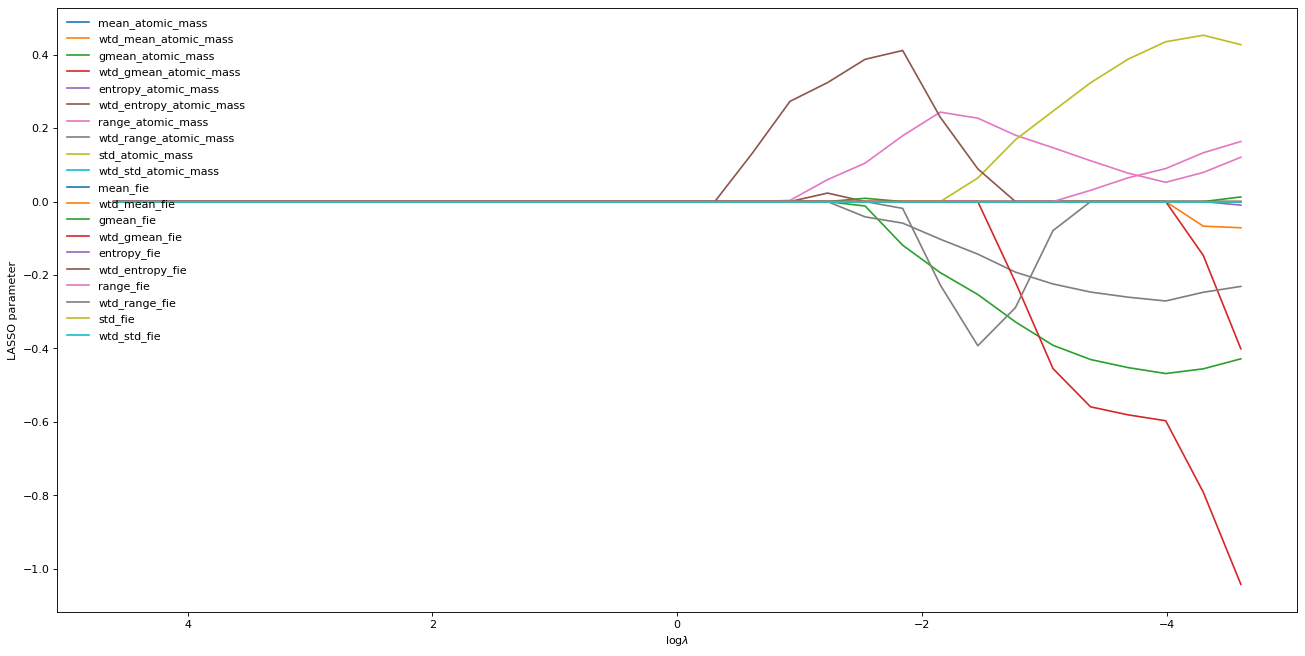

In [23]:
reg_path = compute_reg_path(X, y, alphas)
plot_reg_path(reg_path, alphas, features)

Around the $\log(\lambda)$ mark on the X-axis, the regularlization path shows all of the betas being set to 0 as a result of the penalty. At lower $\log(\lambda)$ values, there is a noticeable trend of the coefficients becoming more extreme, as with the red, green, grey, and yellow lines. Some coefficients have odd behavior in that they become more extreme for a period before going back to 0. 